# Решающие деревья

![](https://i0.wp.com/dataaspirant.com/wp-content/uploads/2017/01/B03905_05_01-compressor.png?resize=768%2C424)

Решающие деревья - алгоритм МО, с помощью которого можно решать задачи классификации и регрессии. Основная идея алгортитма - это поиск условий принятия решений по тренировочным данным. У нас получается такое особое дерево поиска, в котором в узлах вопросы к данным на основе признаков, а в листовых узлах - метки классов. Во время обучения строится это дерево решений, причем так, чтобы оно было максимально эффективным - у него было хорошее качество предсказания и оно не было неоптимальным(слишком глубоким или несбалансированным).

## Литература

- [Habrahabr: ODS деревья решений](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy)
- [ВМК МГУ семинары по решающим деревьям](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem04_trees.pdf)
- [Sklearn Decision Trees](http://scikit-learn.org/stable/modules/tree.html)

### Прежде, чем начать

Установите graphviz введя следующие команды в терминал: <p>
`sudo apt install graphviz`

и 
`pip3 install graphviz` <p>
или `pip install graphviz` если вы используюте pyenv (не забудьте сначала активировать окружение).<p>
(в colab всё и так установлено).



In [78]:
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import entropy as sp_entropy

%matplotlib inline

# Зафиксируем случайность, чтобы каждый раз получалось одно и тоже
np.random.seed(seed=42)

## Рассмотрим как строится дерево

In [79]:
from sklearn.tree import export_graphviz
import graphviz

In [80]:
import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

In [81]:
data = pd.DataFrame({'Возраст': [17,64,18,20,38,49,55,25,29,31,33], 
             'Невозврат кредита': [1,0,1,0,1,0,0,1,1,0,1]})

data.sort_values('Возраст')

,Возраст,Невозврат кредита
0,17,1
2,18,1
3,20,0
7,25,1
8,29,1
9,31,0
10,33,1
4,38,1
5,49,0
6,55,0


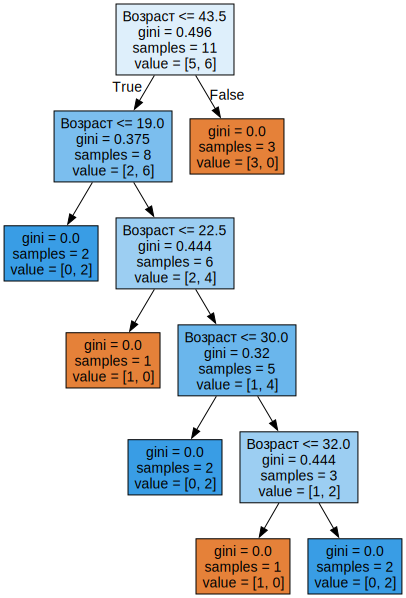

In [82]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(data['Возраст'].values.reshape(-1, 1), data['Невозврат кредита'].values)

dot_data = export_graphviz(clf, feature_names=['Возраст'], filled=True, out_file=None)
graphviz.Source(dot_data) 

In [83]:
data2 = pd.DataFrame({'Возраст':  [17,64,18,20,38,49,55,25,29,31,33], 
                      'Зарплата': [25,80,22,36,37,59,74,70,33,102,88], 
             'Невозврат кредита': [1,0,1,0,1,0,0,1,1,0,1]})

data2.sort_values('Зарплата')

,Возраст,Зарплата,Невозврат кредита
2,18,22,1
0,17,25,1
8,29,33,1
3,20,36,0
4,38,37,1
5,49,59,0
7,25,70,1
6,55,74,0
1,64,80,0
10,33,88,1


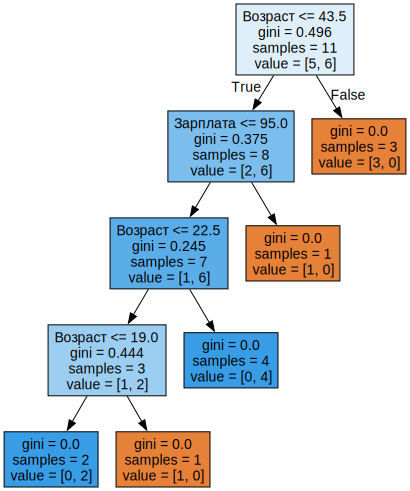

In [84]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(data2[['Возраст', 'Зарплата']].values, data2['Невозврат кредита'].values)

dot_data = export_graphviz(clf, feature_names=['Возраст', 'Зарплата'], filled=True, out_file=None)
graphviz.Source(dot_data) 

## Растим дерево

Прежде всего, для этого нам понадобится метрика неопределённости (impurity metric). 

Для классификации чаще всего предлагают следующие две:
<!-- 
![picture](https://drive.google.com/uc?export=view&id=1DjsVDWXvKPs-cLbl8y9o-OozD_a7u1U-) -->

- энтропия: $\sum_k{p_{ik}log_2(p_{ik})}$

- индекс Джини: $\sum_{j\neq k}p_{ij}p_{ik} = 1 - \sum_k p_{ik}^2$

где $i$ - ID узлов дерева;

$k, j$ - идентификаторы классов, представленных в датасете;

$p_{ik} = \frac{N_{ik}}{N_i}$, 

$p_{ik}$ - вероятность принадлежности класса $k$ узлу $i$,

$N_{ik}$ - число объектов класса $k$ в узле $i$,

$N_{i}$ - общее число объектов в узле $i$.


In [85]:
def gini_index(y: np.ndarray) -> float:
    if len(y) == 0:
        return 0.0

    # Считаем частоты разных классов
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)

    gini = 1.0 - np.sum(probabilities ** 2)
    return gini



sample = np.array([1,1,2,3,3,3,3,3,3,3,1,2,3,1])
assert np.abs(gini_index(sample) - 0.5714285714285714) < 0.000000001
assert gini_index(np.array([1,1,1,1,1,1])) == 0.0
assert gini_index(np.array([1,2,1,2])) == 0.5


In [86]:
def entropy(y: np.ndarray) -> float:
    """Вычисляет энтропию выборки.

    Args:
      y: массив меток классов, например [1,2,3,1,4,2]

    Returns:
      float: значение энтропии
    """
    if len(y) == 0:
        return 0.0

    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)

    # Вычисляем энтропию
    entropy = -sum([probability * np.log2(probability) for probability in probabilities])
    # print(entropy)
    # print(sp_entropy(counts, base=2))
    return entropy


# В ОРИГИНАЛЬНОМ КОДЕ СКОРЕЕ ВСЕГО ОШИБКА
# Написал функцию, считающую энтропию - вылетает ошибка на сравнении, взял из библиотеки - аналогично. Вручную тоже результат иной
sample = np.array([1,1,2,3,3,3,3,3,3,3,1,2,3,1])
# assert np.abs(entropy(sample) - 0.9556998911125343) < 0.000000001
assert entropy(np.array([1,1,1,1,1,1])) == 0.0
# assert np.abs(entropy(np.array([1,2,1,2])) - 0.6931471805599453) < 0.000000001

# Если конкретно, то проверка должна быть на значения
print(entropy(sample))
print(entropy(np.array([1,2,1,2])))

1.3787834934861753
1.0


### Узел решающего дерева
Он будет содержать как поля:
- значение целевого признака
- номер колонки признака
- величину примеси
- ссылки на левый и правый потомок в дереве(на всякий случай)) 

Узел умееть делать предсказание.

**Hint:** метод predict проверяет, является ли данный узел листом и в зависимости от этого либо возвращает значение, либо вызывает этот метод у дочерних узлов.

In [87]:
class TreeNode:
    def __init__(
        self, 
        impurity=sys.float_info.max, 
        target_value=None,
        is_leaf=True,
        condition_column=None,
        condition_value=None,
        left_child=None,
        right_child=None,
    ):
        self.left_child: TreeNode = left_child  # левое ответвление
        self.right_child: TreeNode = right_child  # правое ответвление
        self.is_leaf = is_leaf  # флаг, является ли этот узел терминльным (то есть листом)

        self.target_value = target_value  # значение целевого признака, которое предсказывает этот узел дерева
        
        self.condition_column = condition_column  # id столбца, по которому будет делаться ветвление в этом узле дерева
        self.condition_value = condition_value  # значение, величины, по которой было сделано ветвление
        self.impurity = impurity  # значение неопределённости для этого узла

    def predict(self, x):
        """
        Рекурсивный метод для предсказания значения целевого признака.

        Args:
            x: np.ndarray или список признаков для одного объекта.

        Returns:
            target_value: предсказанное значение целевого признака.
        """
        predictions = [self._predict_for_one(k) for k in x]
        return np.array(predictions)

    def _predict_for_one(self, x):
        # Если текущий узел является листом, возвращаем его
        if self.is_leaf:
            return self.target_value
        
        # Иначе, переходим к дочерним узлам в зависимости от условия
        if x[self.condition_column] <= self.condition_value:
            return self.left_child._predict_for_one(x)  # левое поддерево
        else:
            return self.right_child._predict_for_one(x)  # правое поддерево

#### Теперь можно приступить к реализации алгоритма построения дерева.

На псевдокоде он выглядит вот так:
```python
def build(L):
    create node t
    if the stopping criterion is True:
        assign a predictive model to t
    else:
        Find the best binary split L = L_left + L_right
        t.left = build(L_left)
        t.right = build(L_right)
    return t
```
Как вы можете заметить, он рекурсивный.

Сначала напишем функцию, осуществляющую формирование одного узла дерева (ту самую, которую мы будем вызывать рекурсивно).

Прекращать дробление выборки и создавать новые узлы будем, если
- В текущем узле все элементы относятся к одному классу
- Information Gain наилучшего возможного разбиения отрицательный

Information Gain ($IG$) определяется как

$ IG = S_{orig} - \frac{N_{left}}{N}S_{left} - \frac{N_{right}}{N}S_{right}$, где 

$S_{orig}$ - неопределённость для всей выборки на текущем шаге

$S_{left}, S_{right}$ - неопределённость на частях текущего разбиения

$\frac{N_{i}}{N}$ - доля подвыборки для $i$-й части разбиения относительно исходной выборки

В этой формуле $\frac{N_{left}}{N}S_{left} + \frac{N_{right}}{N}S_{right}$ - неопределённость для нового разбиения, давайте посчитаем его отдельно.

In [88]:
def new_split_impurity(y_left: np.ndarray, y_right: np.ndarray, impurity_metric) -> float:
    """Вычисляет неопределенность для разбиения по формуле выше.

    Args:
      y_left: метки классов подвыборки для левой поддерева вида [1,1,2,3,4,5]
      y_right: метки классов подвыборки для правого поддерева вида [1,1,2,3,4,5]
      impurity_metric: функция, вычисляющая метрику неопрделенности, например gini или entropy
    
    Returns: 
      float: неопределенность разбиения
    """
    # Длины выборок
    n_left = len(y_left)
    n_right = len(y_right)
    n_total = n_left + n_right

    if n_total == 0:
        return 0.0  # Если нет элементов, неопределённость разбиения = 0

    # неопределённости для каждой подвыборки
    impurity_left = impurity_metric(y_left) if n_left > 0 else 0.0
    impurity_right = impurity_metric(y_right) if n_right > 0 else 0.0

    # неопределённость разбиения
    split_impurity = (n_left / n_total) * impurity_left + (n_right / n_total) * impurity_right
    return split_impurity

In [89]:
a = np.asarray([0,0,1,1,1])
gi = gini_index(a)
print('Default impurity is', gi)
assert gi == 0.48

# делаем разбиение данных
l, r = np.split(a, [2])
# l, r = a[:2], a[2:] # это тоже самое что и np.split, но функция не создает копии данных
print(l, r)

si = new_split_impurity(l, r, gini_index)
print(f'Impurity after splitting into {l} and {r} is', si)
assert si == 0

del a, l, r, gi, si

Default impurity is 0.48
[0 0] [1 1 1]
Impurity after splitting into [0 0] and [1 1 1] is 0.0


Реализуйте функцию выбора класса для текущего листа.
Будет достаточно выбрать наиболее часто встречающийся класс, или один из таких.

In [90]:
from collections import Counter

In [91]:
def find_dominant_class(y: np.ndarray):
    """Возвращает наиболее часто встречающийся класс в выборке.

    Args:
      y: массив меток классов, например [1,2,4,2,3,1]
    Returns:
      object: самый часто встречающийся класс. Может быть строкой, если лейблы у нас это строки, а не индексы.
    """
    # Проверка на пустой массив
    if len(y) == 0:
        return None

    # Подсчитываем частоты классов
    counter = Counter(y)

    # Находим класс с максимальной частотой
    dominant_class = max(counter, key=counter.get)
    return dominant_class

In [92]:
most_freq = find_dominant_class([1,2,"кочерыжка", 1,"кочерыжка", "кочерыжка"])
print(f'The most common class is "{most_freq}"')

assert most_freq == 'кочерыжка'
del most_freq

The most common class is "кочерыжка"


#### Реализация алгоритма решающего дерева
Реализуйте метод построения дерева на основе описания, указанного выше.

Для этого Вам понадобится дополнительная функция, которая выбирает наиболее подходящее разбиение.

Разбиение в данной вариации делается по одному столбцу в данных. (Соответственно, нужно сначала подготавливать столбец к поиску разбиений)

In [93]:
def get_split_values(x):
    x = np.array(x)
    
    if np.issubdtype(x.dtype, np.number):
        # Для числовых данных: сортируем уникальные значения и вычисляем середины между ними
        unique_values = np.unique(x)
        split_values = (unique_values[:-1] + unique_values[1:]) / 2
        return split_values
    else:
        # Для категориальных данных возвращаем уникальные значения
        return np.unique(x)


print(get_split_values([1,2,3,4,5,6]) == np.array([1.5, 2.5,3.5,4.5,5.5]))
print(get_split_values([1,2,7,88,12,346,12,6,2,4,6,1,1,12,88]) == np.array([1.5, 3, 5, 6.5, 9.5, 50, 217]))

[ True  True  True  True  True]
[ True  True  True  True  True  True  True]


In [94]:
def find_best_split(x, y: np.ndarray, impurity_metric):
    """
    Args:
      x: матрица признаков данных
      y: список меток классов, другими словами - это столбец целевых признаков
      impurity_metric: функция для вычисления неопределенности выборки
    
    Returns:
      min_impurity:
      best_split_col:
      best_split_value:
    """
    min_impurity = np.inf
    best_split_col = None
    best_split_value = None

    # Перебираем признаки
    for col in range(x.shape[1]):
        # Получаем все уникальные значения для текущего столбца
        split_values = get_split_values(x[:, col])

        for value in split_values:
            left_mask = x[:, col] <= value
            right_mask = ~left_mask

            y_left, y_right = y[left_mask], y[right_mask]

            if len(y_left) == 0 or len(y_right) == 0:
                continue

            split_impurity = new_split_impurity(y_left, y_right, impurity_metric)

            if split_impurity < min_impurity:
                min_impurity = split_impurity
                best_split_col = col
                best_split_value = value

    return min_impurity, best_split_col, best_split_value


## ТЕСТЫ

data2 = pd.DataFrame({
    'Возраст':  [17,64,18,20,38,49,55,25,29,31,33], 
    'Зарплата': [25,80,22,36,37,59,74,70,33,102,88], 
    'Невозврат кредита': [1,0,1,0,1,0,0,1,1,0,1]
})

X_test = data2[['Возраст', 'Зарплата']].values
y_test = data2['Невозврат кредита']

min_impurity_, best_split_col_, best_split_value_ = find_best_split(X_test, y_test, gini_index)
assert min_impurity_ == 0.2727272727272727
assert best_split_col_ == 0
assert best_split_value_ == 43.5


mask = X_test[:, best_split_col_] >= best_split_value_


min_impurity_, best_split_col_, best_split_value_ = find_best_split(X_test[~mask], y_test[~mask], gini_index)
assert min_impurity_ == 0.21428571428571433
assert best_split_col_ == 1
assert best_split_value_ == 95

min_impurity_, best_split_col_, best_split_value_ = find_best_split(X_test[mask], y_test[mask], gini_index)
assert min_impurity_ == 0
assert best_split_col_ == 0
assert best_split_value_ == 52

In [95]:
def build_next_node(x: np.ndarray, y: np.ndarray, impurity_metric) -> TreeNode:
    # Если все элементы принадлежат одному классу, создаем листовой узел
    if np.all(y == y[0]):
        return TreeNode(target_value=y[0], is_leaf=True)
    
    # Ищем наилучшее разбиение
    min_impurity, best_split_col, best_split_value = find_best_split(x, y, impurity_metric)
    
    # Если неопределенность не уменьшается, создаем листовой узел с наиболее частым классом
    if min_impurity >= impurity_metric(y):
        dominant_class = find_dominant_class(y)
        return TreeNode(target_value=dominant_class, is_leaf=True)
    
    # Разделяем данные на две подвыборки
    left_mask = x[:, best_split_col] <= best_split_value
    right_mask = ~left_mask
    x_left, y_left = x[left_mask], y[left_mask]
    x_right, y_right = x[right_mask], y[right_mask]

    # Рекурсивно строим дочерние узлы
    left_node = build_next_node(x_left, y_left, impurity_metric)
    right_node = build_next_node(x_right, y_right, impurity_metric)
    
    # Создаем и возвращаем текущий узел
    return TreeNode(
        impurity=min_impurity,
        target_value=None,  # Значение целевого признака для внутреннего узла будет вычисляться на основе дочерних узлов
        is_leaf=False,
        condition_column=best_split_col,
        condition_value=best_split_value,
        left_child=left_node,
        right_child=right_node
    )

data2 = pd.DataFrame({
    'Возраст':  [17,64,18,20,38,49,55,25,29,31,33], 
    'Зарплата': [25,80,22,36,37,59,74,70,33,102,88], 
    'Невозврат кредита': [1,0,1,0,1,0,0,1,1,0,1]
})

X_test = data2[['Возраст', 'Зарплата']].values
y_test = data2['Невозврат кредита'].values

clf = build_next_node(X_test, y_test, gini_index)

print(clf.predict(X_test))
assert np.all(clf.predict(X_test) == y_test)

[1 0 1 0 1 0 0 1 1 0 1]


## Визуализация предсказаний

Рассмотрим как справляются с задачей классификации 3 алгоритма - линейный, ближайшие соседи и решающее дерево на синтетическом примере - две луны и кольца.

In [96]:
# Вспомогательная функция для генерации точек на всей поверхности scatter plot
def get_grid(X, y, step=0.01):
    x_min, x_max = X.min() - 1, X.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    return np.meshgrid(np.arange(x_min, x_max, step),
                         np.arange(y_min, y_max, step))

# Вспомогательная функция которая покрасит всё пространство
def fill_color(clf, X, y, cmap=plt.cm.RdYlBu, proba=True, step=0.01):
    xx, yy = get_grid(X, y, step)
    if proba and hasattr(clf, 'predict_proba'):
        predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1].reshape(xx.shape)
    else:
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contourf(xx, yy, predicted, cmap=cmap, alpha=.8)

Text(0, 0.5, 'Зарплата')

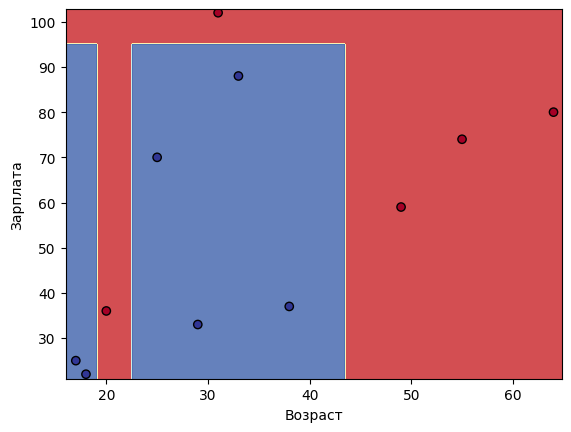

In [97]:
data2 = pd.DataFrame({
  'Возраст':  [17,64,18,20,38,49,55,25,29,31,33], 
  'Зарплата': [25,80,22,36,37,59,74,70,33,102,88], 
  'Невозврат кредита': [1,0,1,0,1,0,0,1,1,0,1]
})

clf = DecisionTreeClassifier(random_state=42)
clf.fit(data2[['Возраст', 'Зарплата']].values, data2['Невозврат кредита'].values)


fill_color(clf, data2['Возраст'], data2['Зарплата'], cmap=plt.cm.RdYlBu, proba=False, step=0.2)
plt.scatter(data2['Возраст'], data2['Зарплата'], c=data2['Невозврат кредита'], cmap=plt.cm.RdYlBu, edgecolors='k')
plt.xlabel('Возраст')
plt.ylabel('Зарплата')

Text(0, 0.5, 'Зарплата')

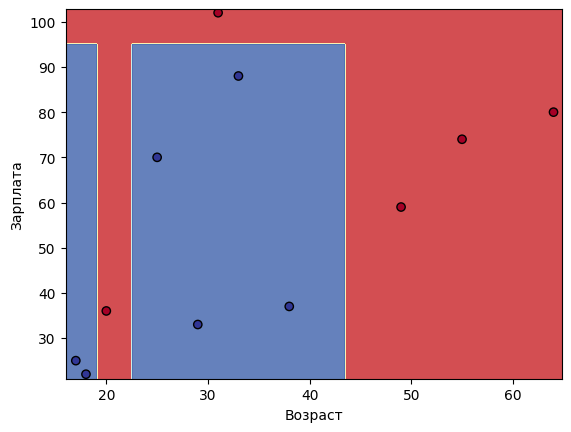

In [98]:
data2 = pd.DataFrame({
  'Возраст':  [17,64,18,20,38,49,55,25,29,31,33], 
  'Зарплата': [25,80,22,36,37,59,74,70,33,102,88], 
  'Невозврат кредита': [1,0,1,0,1,0,0,1,1,0,1]
})

clf = build_next_node(
  data2[['Возраст', 'Зарплата']].values,
  data2['Невозврат кредита'].values,
  gini_index
)

fill_color(clf, data2['Возраст'], data2['Зарплата'], cmap=plt.cm.RdYlBu, proba=False, step=0.2)
plt.scatter(data2['Возраст'], data2['Зарплата'], c=data2['Невозврат кредита'], cmap=plt.cm.RdYlBu, edgecolors='k')
plt.xlabel('Возраст')
plt.ylabel('Зарплата')

## Две Луны

In [99]:
from sklearn.datasets import make_moons, make_circles, make_classification

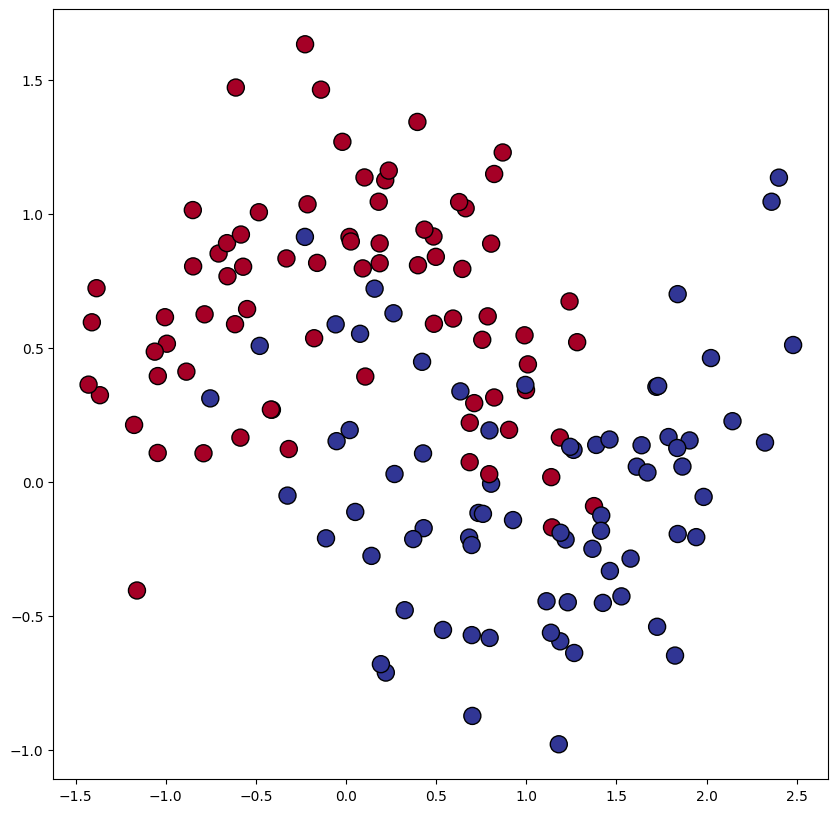

In [100]:
X, y = make_moons(n_samples=150, noise=0.3, random_state=42)

plt.figure(figsize=(10,10))

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=150)

Для начала посмотрим, как с задачей справится линейная регрессия. Дополнительно вызвав функцию `fill_color` покрасим все пространство, чтобы видеть как меняется решение модели, на основе плавного изменения признка.  
Понятно, почему мы видим линии как разделители поверхностей. У нас же линейная модель!

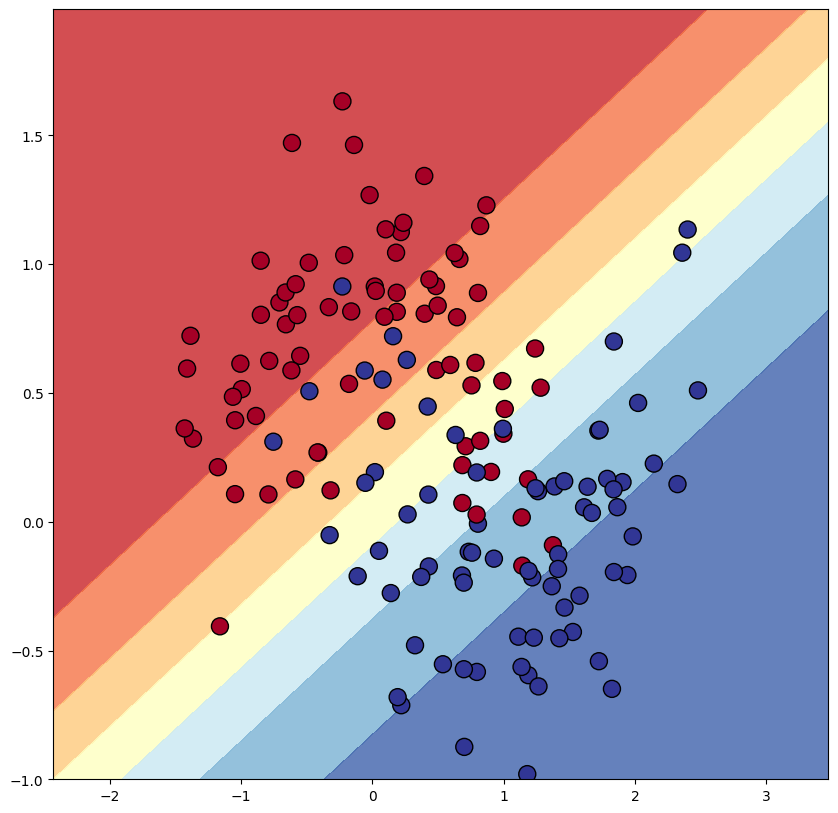

In [101]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs')
clf.fit(X, y)

plt.figure(figsize=(10,10))
fill_color(clf, X, y, cmap=plt.cm.RdYlBu)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=150)

А K ближайших соседей работает немного по-другому. Видно, что это модель может уловить нелинейную взаимосвзять между признаками и целевым признаком. Пространство предсказания разукрасилось плавно.

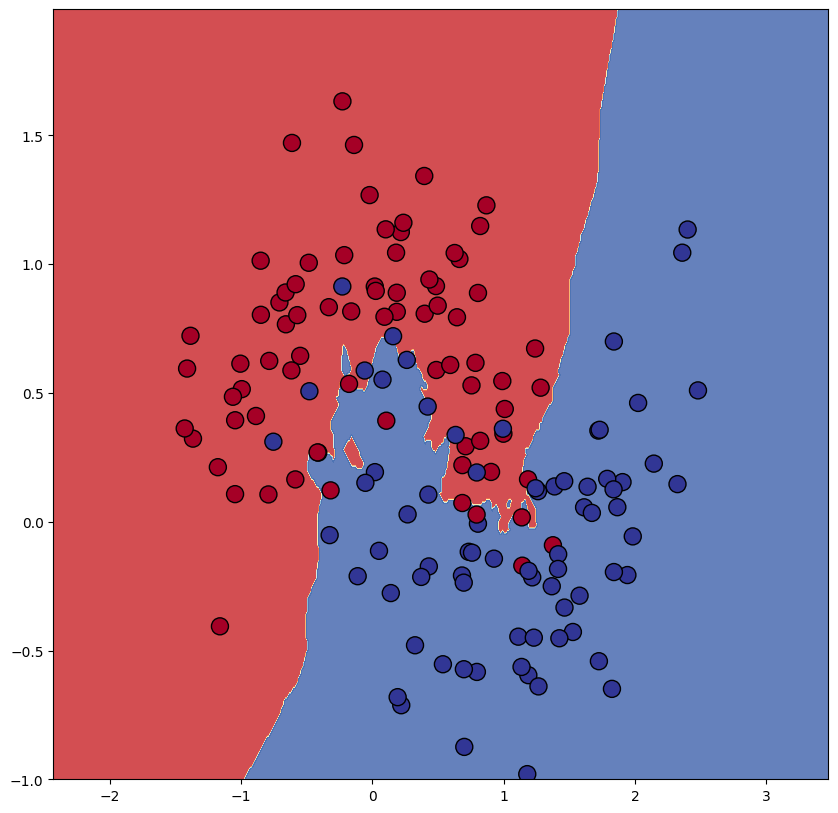

In [102]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(7)
clf.fit(X, y)

plt.figure(figsize=(10,10))
fill_color(clf, X, y, cmap=plt.cm.RdYlBu, proba=False)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=150)

Решающие деревья разбивают пространство на прямоугольники, "выцепляя" объекты.

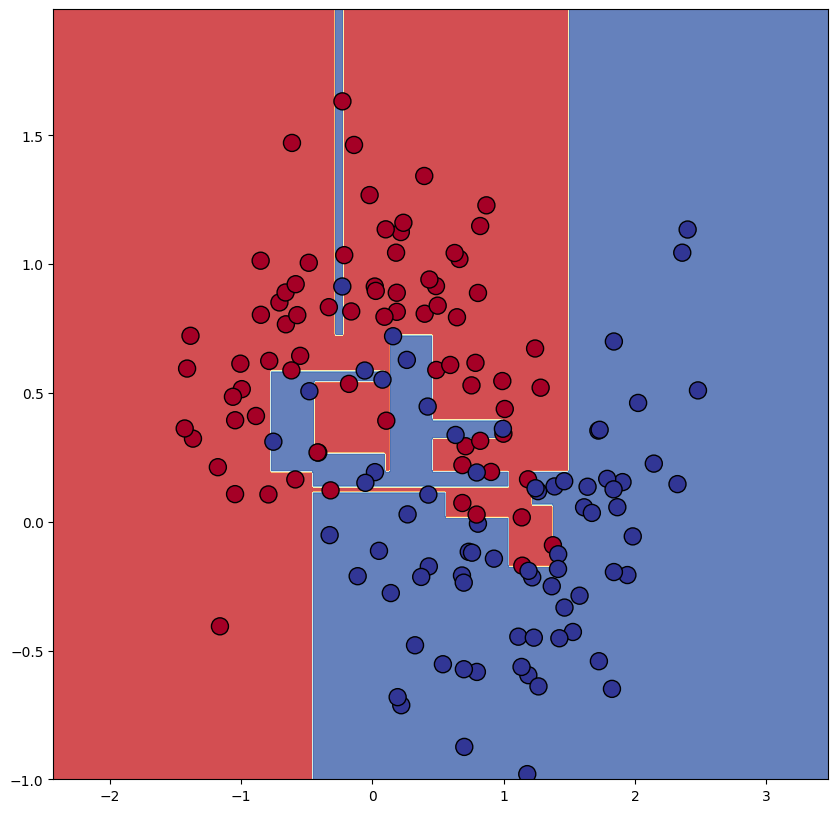

In [103]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X, y)

plt.figure(figsize=(10,10))
fill_color(clf, X, y, cmap=plt.cm.RdYlBu)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=150)

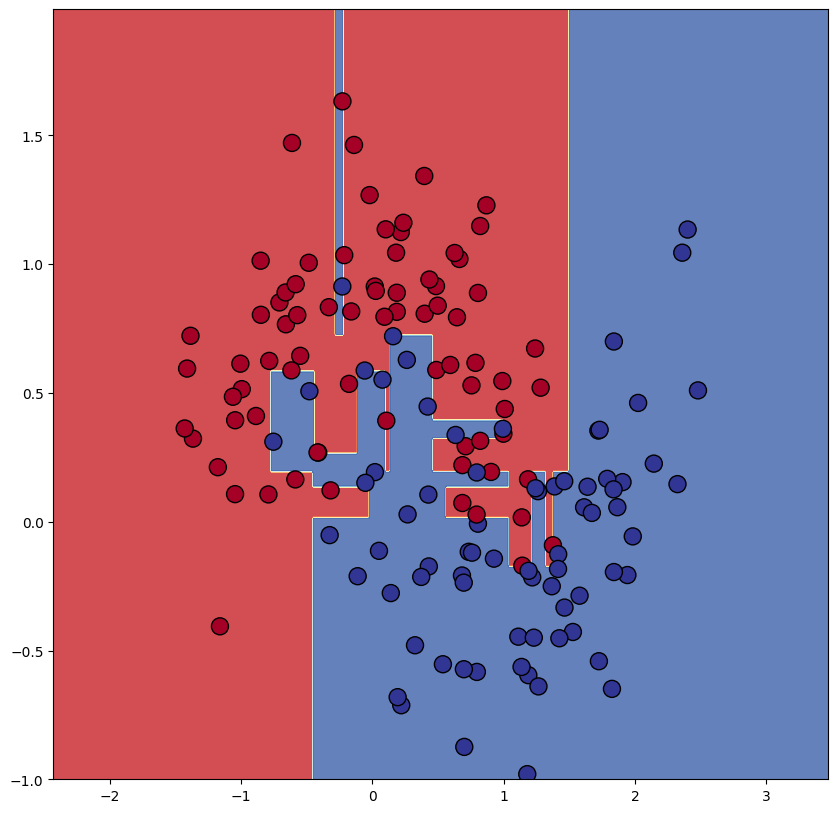

In [104]:
clf = build_next_node(X, y, gini_index)

plt.figure(figsize=(10,10))
fill_color(clf, X, y, cmap=plt.cm.RdYlBu)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=150)

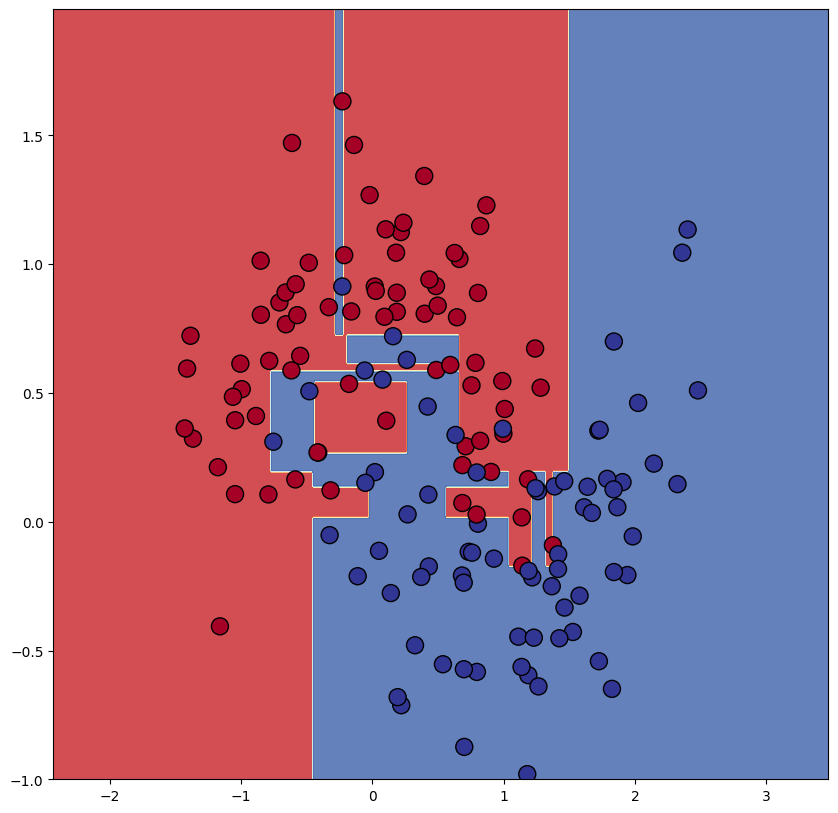

In [105]:
clf = build_next_node(X, y, entropy)

plt.figure(figsize=(10,10))
fill_color(clf, X, y, cmap=plt.cm.RdYlBu)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=150)

## Кольца

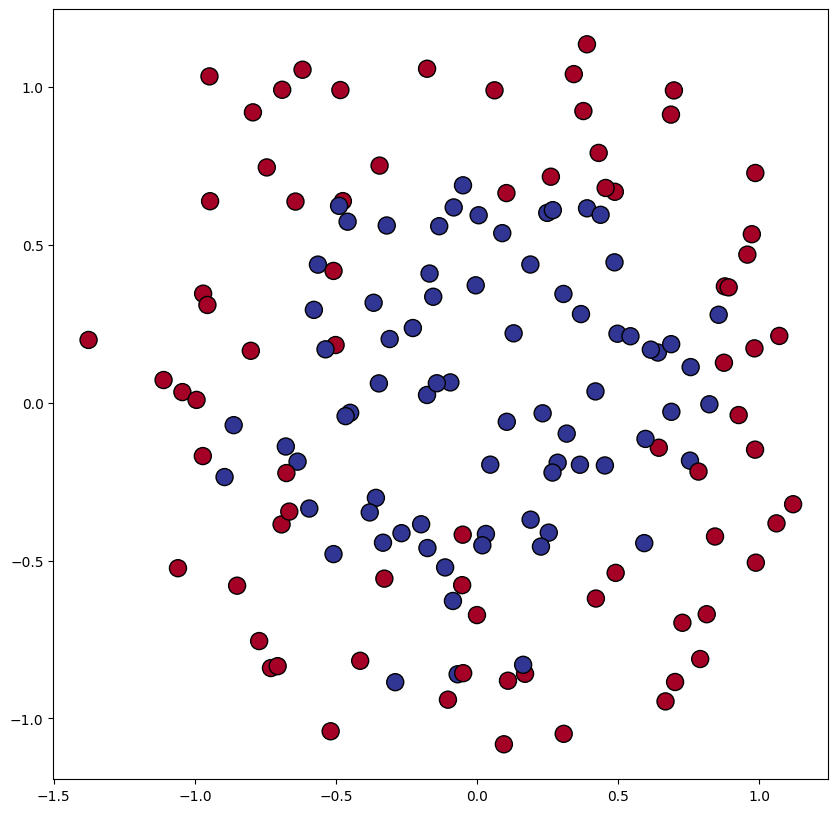

In [106]:
X, y = make_circles(n_samples=150, noise=0.2, factor=0.5, random_state=1)

plt.figure(figsize=(10,10))

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=150)

Линейной модели совсем сложно справиться с такой задачей, так как объекты невозможно отделить одной прямой линией. (Но если применить трюк с переходом в другие координаты......)

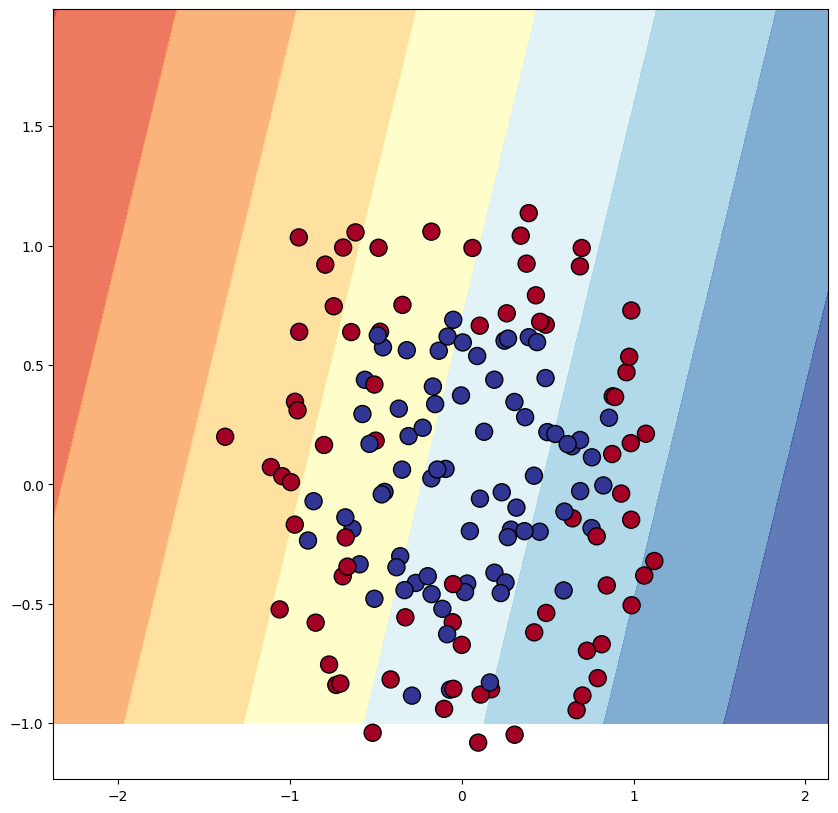

In [107]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs')
clf.fit(X, y)

plt.figure(figsize=(10,10))
fill_color(clf, X, y, cmap=plt.cm.RdYlBu)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=150)

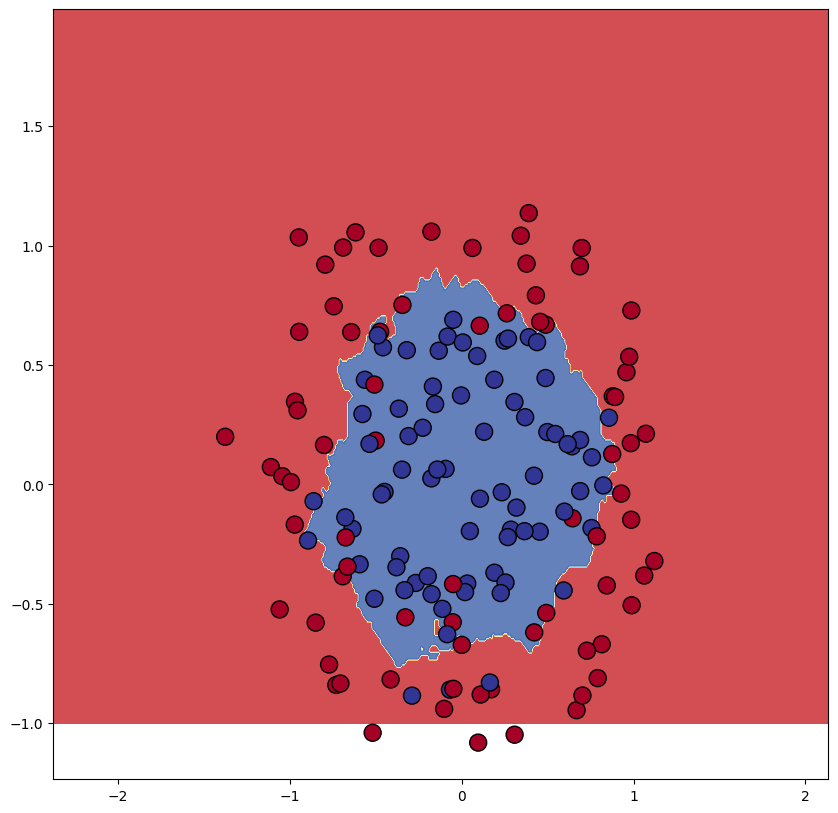

In [108]:
clf = KNeighborsClassifier(7)
clf.fit(X, y)

plt.figure(figsize=(10,10))
fill_color(clf, X, y, cmap=plt.cm.RdYlBu, proba=False)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=150)

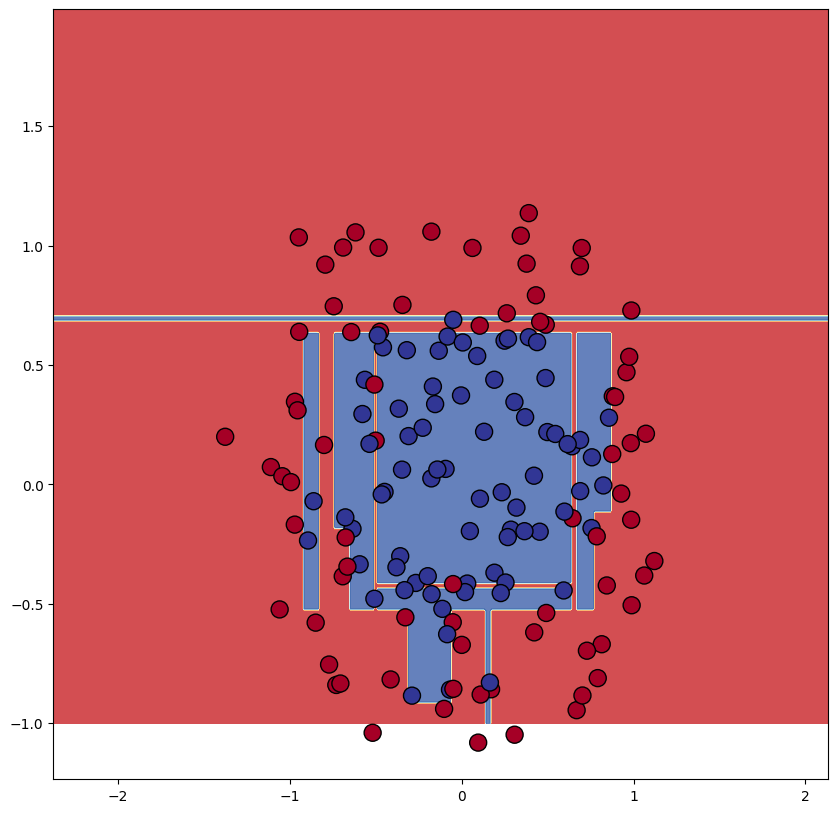

In [109]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X, y)

plt.figure(figsize=(10,10))
fill_color(clf, X, y, cmap=plt.cm.RdYlBu)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=150)

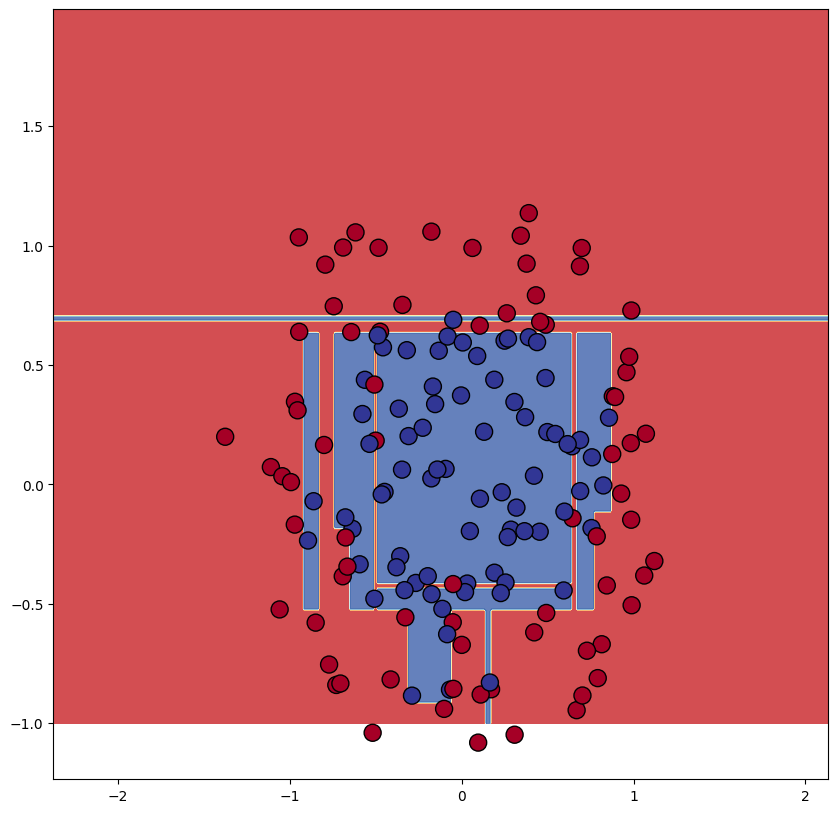

In [110]:
clf = build_next_node(X, y, gini_index)

plt.figure(figsize=(10,10))
fill_color(clf, X, y, cmap=plt.cm.RdYlBu)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=150)

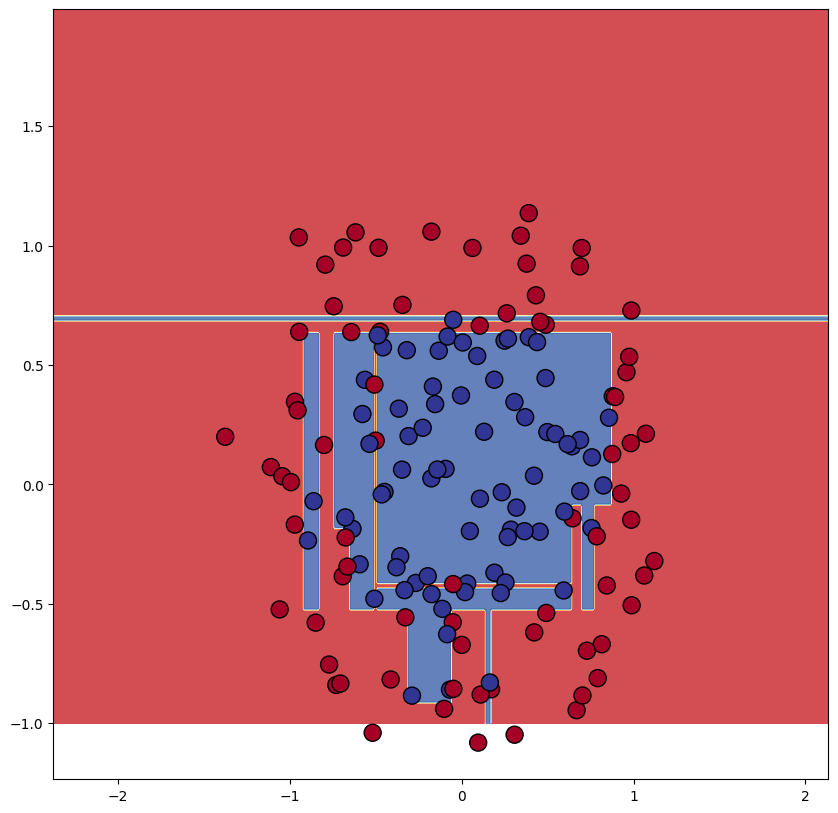

In [111]:
clf = build_next_node(X, y, entropy)

plt.figure(figsize=(10,10))
fill_color(clf, X, y, cmap=plt.cm.RdYlBu)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=150)

## Неустойчивость деревьев

Неустойчивость к изменениям в данных.

В отличие от весьма стабильных алгоритмов kNN и линейной классификации, дерево решений очень сильно меняется в зависимости от фазы луны и формы данных. Если мы добавим еще один элемент, то может всё сильно измениться, давайте посмотрим!

**Спойлер**: но этот недостаток делает их сильнее, когда их много!!

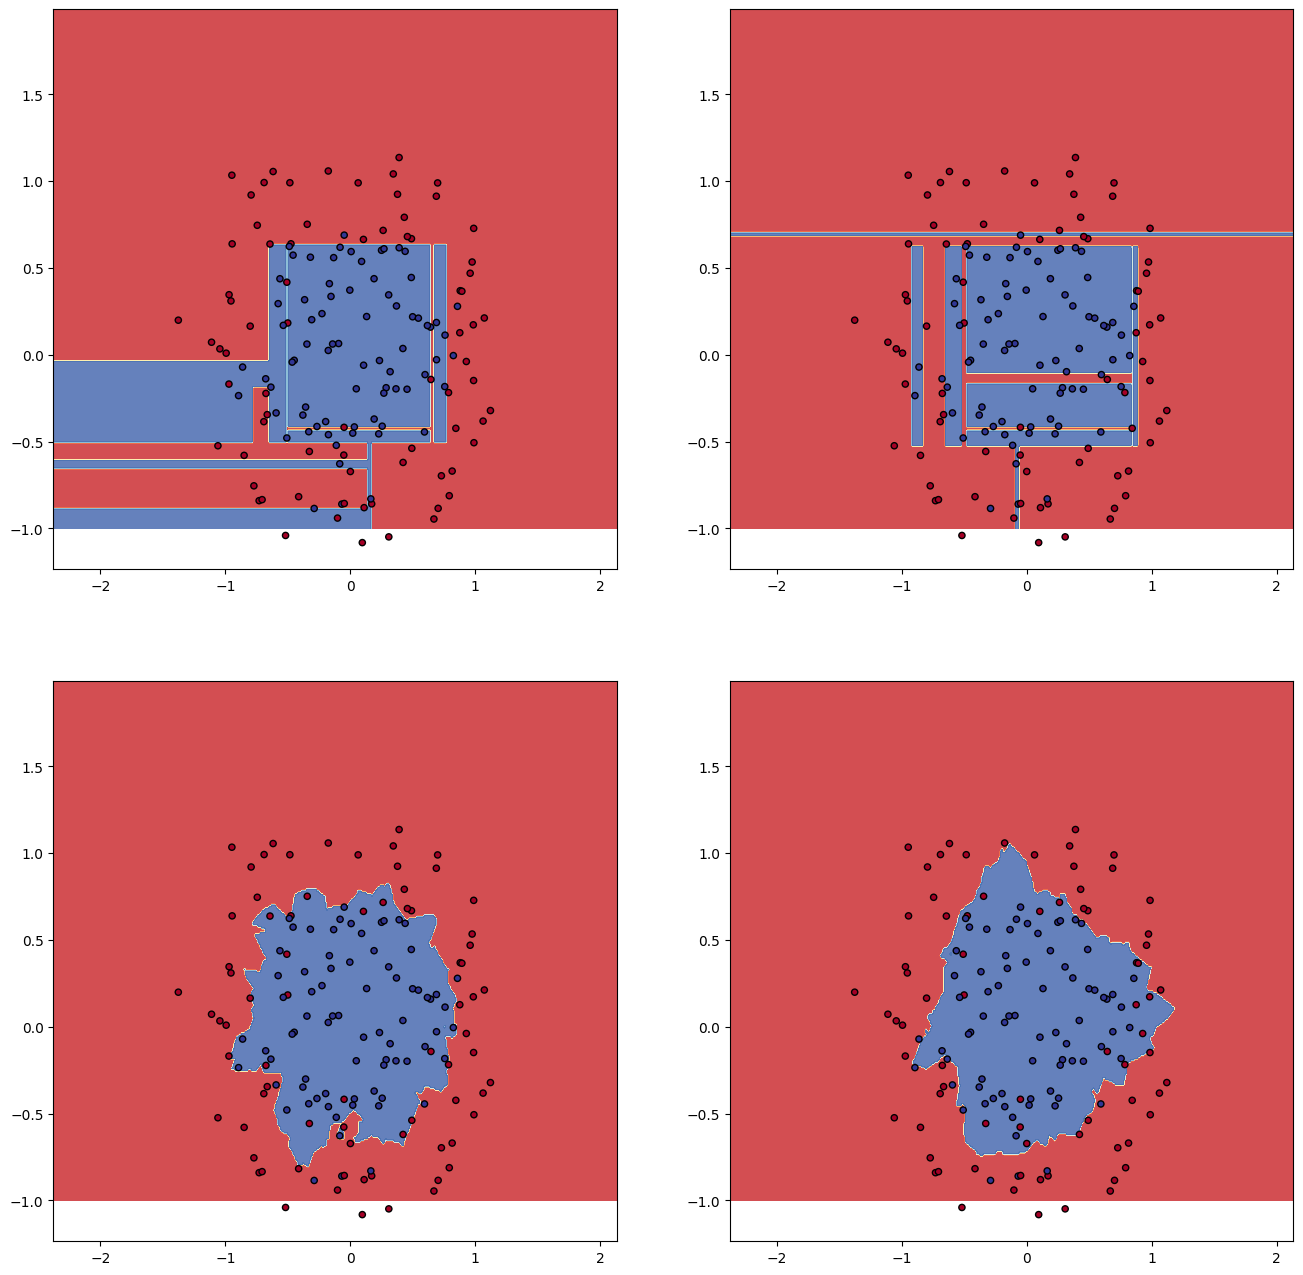

In [112]:
X, y = make_circles(n_samples=150, noise=0.2, factor=0.5, random_state=1)

plt.figure(figsize=(16,16))

X1, y1 = X[40:], y[40:]
X2, y2 = X[:110], y[:110]

#################### Tree ##################

clf = build_next_node(X1, y1, gini_index)
plt.subplot(221)
fill_color(clf, X, y, cmap=plt.cm.RdYlBu)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=20)

clf = build_next_node(X2, y2, gini_index)
plt.subplot(222)
fill_color(clf, X, y, cmap=plt.cm.RdYlBu)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=20)

#################### KNN ########################

clf = KNeighborsClassifier(5)
clf.fit(X1, y1)
plt.subplot(223)
fill_color(clf, X, y, cmap=plt.cm.RdYlBu, proba=False)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=20)

clf = KNeighborsClassifier(5)
clf.fit(X2, y2)
plt.subplot(224)
fill_color(clf, X, y, cmap=plt.cm.RdYlBu, proba=False)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu, edgecolor='black', s=20)

## Регрессия


Теперь реализуем метрику под названием Остаточная Сумма Квадратов (Residual sum of squares).

$RSS = \sum_{j=1}^N(y_j - \mu_{[j]})^2$

где $\mu_{[j]}$ - это среднее всех значений из разбиения, к которому принадлежит $j$-й элемент.

In [113]:
def residual_sum_of_squares(y):
    # поскольку метрику мы считаем для каждого разбиения отдельно, то мы можем брать здесь среднее от всей выборки, т.к. по сути здесь у нас всего один узел
    return np.sum(np.power(y - y.mean(), 2))

Теперь настало время переделать нашу функцию под регрессию. Первая и самая важная вещь, которую стоит помнить это то, что в отличие от классификации, здесь все значения могут быть уникальными и их может быть бесконечно много (если, конечно, игнорировать ограничения, диктуемые нам "железом").

Давайте вспомним наши критерии останова, взятые для классификации:
- В текущем узле все элементы относятся к одному классу
- Information Gain наилучшего возможного разбиения отрицательный

Сразу же можно понять, что первый критерий теперь не подходит нам, т.к. он всегда будет приводить нас к переобученному дереву (тому, у которого на каждый элемент выборки приходится свой отдельный лист)
В такой ситуации возможны, как минимум, три выхода:
1. Оставить его как есть и получать в конце переобученное дерево (впрочем, в sklearn так и делают)
2. Ввести дополнительные ограничения, например на глубину дерева, минимальное количество объектов, относящихся к каждому листу дерева (есть в sklearn как опции)
3. Останавливать обучение, когда достигнута какая-то величина метрики неопределённости - по сути говоря, это почти то же самое, что задавать максимальную допустимую величину разности между двумя произвольными объектами в этом разбиении. Такой способ не требует никаких дополнительных условий, но это не очень надёжный способ, т.к. величина RSS напрямую зависит от масштаба характеристических признаков.

Ещё можно "обрезать" переобученное дерево после построения, как советовали Брейман и Ко в описании алгоритма CART. Но это уже совсем другая история...

Так, ладно, сначала попробуем натренировать дерево регрессии не меняя алгоритм. Оно должно получиться глубоким, но точным.

Для этого загрузим датасет с ценами на жильё в Бостоне. Будем тестировать модель, предсказывая медианное значение цены на несъёмное жильё.

In [114]:
from sklearn.datasets import load_boston

data = load_boston()
print(data.DESCR)

ImportError: 
`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]

Alternative datasets include the California housing dataset and the
Ames housing dataset. You can load the datasets as follows::

    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing()

for the California housing dataset and::

    from sklearn.datasets import fetch_openml
    housing = fetch_openml(name="house_prices", as_frame=True)

for the Ames housing dataset.

[1] M Carlisle.
"Racist data destruction?"
<https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8>

[2] Harrison Jr, David, and Daniel L. Rubinfeld.
"Hedonic housing prices and the demand for clean air."
Journal of environmental economics and management 5.1 (1978): 81-102.
<https://www.researchgate.net/publication/4974606_Hedonic_housing_prices_and_the_demand_for_clean_air>


In [ ]:
df = pd.DataFrame(data.data, columns=data.feature_names)
df['MEDV'] = data.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [ ]:
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(df.drop(['MEDV'], axis=1), df['MEDV'], test_size=100, 
                                        random_state=241)

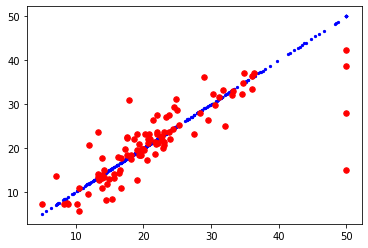

In [ ]:
from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor()
clf.fit(X, y)

plt.scatter(y_test, y_test, color='green', s=1)  # идеальная прямая, чтобы было
plt.scatter(y, clf.predict(X), color='blue', s=5)
plt.scatter(y_test, clf.predict(X_test), color='red', s=30)

Выведем, сколько у дерева получилось листьев.

In [ ]:
clf.get_n_leaves()

386

А теперь давайте сделаем "правильную" версию с регрессией. Можно использовать старый метод, изменить нужно всего-лишь пару строк.

In [ ]:
def count_leaves(node):
    if node.is_leaf:
        return 1
    return count_leaves(node.left_child) + count_leaves(node.right_child)

In [ ]:
def build_next_node_regression(x: np.ndarray, y: np.ndarray, impurity_metric) -> TreeNode:
    pass

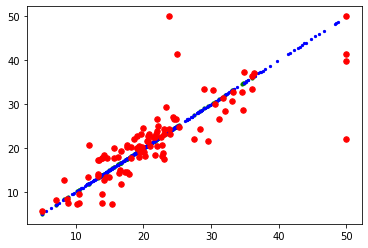

In [ ]:
clf = build_next_node_regression(X.to_numpy(), y.to_numpy(), residual_sum_of_squares)

plt.scatter(y_test, y_test, color='green', s=10)  # идеальная прямая, чтобы было
plt.scatter(y, clf.predict(X.to_numpy()), color='blue', s=5)
plt.scatter(y_test, clf.predict(X_test.to_numpy()), color='red', s=30)

In [ ]:
count_leaves(clf)

391

### А что дальше?

Над деревьями можно делать много разных модификаций:
- Урезать глубину дерева
- Запрещать создавать листья с менее чем $k$ элементами выборки на них
- модифицировать логику выбора класса, если на листе есть элементы разных классов
    - Вычислить вероятности выпадения каждого класса, тем самым задав распределение, и затем, при попадании на этот лист генерировать случайную величину из этого распределения, и считать это предсказанием
    - Так же, вычислить вероятности, а величину выбрать один раз сгенерировав случайную величину
- Объединить много таких деревьев в ансамбли (пожалуй, наиболее перспективная идея)
